# Import library

In [2]:
from En_system_intergrated import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import dartwork_mpl as dm
import calc_util as cu
import seaborn as sns
from scipy.stats import norm, uniform, triang, gamma

# dm.util.use_dmpl_style()
# plt.rcParams['font.family'] = 'Roboto'

Load colors...
Load colormaps...


# Electric boiler

TypeError: unhashable type: 'dict'

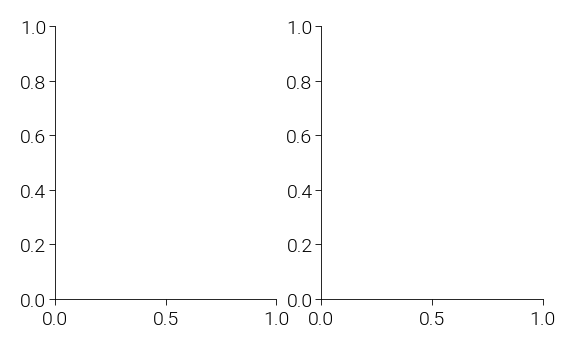

In [5]:
Elec_boiler = ElectricBoiler()
Elec_boiler.T_w_tank = cu.C2K(70)
Elec_boiler.system_update()

# Create figure and axis - adjust figure size for vertical layout
nrows = 1
ncols = 2
fig, ax = plt.subplots(nrows, ncols, figsize=(dm.cm2in(8), dm.cm2in(4.5)), dpi=200, facecolor=None, edgecolor='k')

for idx in range(ncols):
    data = list(Elec_boiler.exergy_balance.values())[idx]
    keys = list(Elec_boiler.exergy_balance.keys())[idx]
    values = list(data.values())
    labels = list(data.keys())

    group_margin = 0.3  # margin between groups
    bar_margin = 0.1  # margin between bars
    bar_width = 0.2

    dN = len(data)  # number of data
    x_pos0 = np.array([i * (bar_margin + bar_width) for i in range(dN)])
    gl1 = [[2, 1, 2], [2, 1, 1], [2, 1, 2], [2, 1, 2]][idx]  # group
    gN = len(gl1)  # number of groups
    gl2 = np.cumsum(gl1)

    x_pos = x_pos0[:gl2[0]].tolist()
    for i in range(gN - 1):  # Add group_margin between arrays
        x_pos.extend((x_pos0[gl2[i]:gl2[i + 1]] + group_margin * (i + 1)).tolist())

    # Plot parameters
    sp_ratio = 0.5
    xmar = bar_width
    xmax = max(x_pos)
    xmin = min(x_pos)
    ymar = 0
    ymax = 3000
    ymin = 0
    yint = 200

    # Create vertical bars
    bars = ax[idx].bar(x_pos, values, bar_width, color=['dm.red6', 'dm.red5', 'dm.yellow6', 'dm.green6', 'dm.lime5'])

    # Annotation
    ax[idx].annotate(f'{keys}', xy=(0.5, 1.1), xycoords='axes fraction', color='dm.gray9',fontweight=500,
                      horizontalalignment='center', verticalalignment='bottom', fontsize=dm.fs(1.5))

    # Add value labels on top of each bar
    for bidx, bar in enumerate(bars):
        height = bar.get_height()
        ax[idx].text(bar.get_x() + bar.get_width() / 2., height + ymax / 150,
                     f'{height:.0f}', ha='center', va='bottom', fontsize=dm.fs(-3), fontweight=400)

    # Axes limits
    ax[idx].set_xlim(xmin - xmar, xmax + xmar)
    ax[idx].set_ylim(ymin - ymar, ymax + ymar)

    # Labels and ticks
    ax[idx].set_xticks(x_pos)
    ax[idx].set_xticklabels(labels, rotation=90, ha='center', fontsize=dm.fs(-1))
    ax[idx].set_yticks([])  # No y-ticks

    # Tick parameters
    ax[idx].tick_params(axis='x', direction='in', labelsize=dm.fs(-1),
                        which='major', length=0, width=0.5 * sp_ratio, pad=300)
    ax[idx].tick_params(axis='x', direction='in', labelsize=dm.fs(-2),
                        which='minor', length=0, width=0.25 * sp_ratio, pad=3)
    ax[idx].tick_params(axis='y', direction='in', labelsize=dm.fs(-2),
                        which='major', length=2, width=0.5 * sp_ratio, pad=3)
    ax[idx].tick_params(axis='y', direction='in', labelsize=dm.fs(-2),
                        which='minor', length=1, width=0.25 * sp_ratio, pad=3)

    # Minor ticks
    ax[idx].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax[idx].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

    # Spines
    for k in ['top', 'left', 'right']:  # Only keep bottom spine
        ax[idx].spines[k].set_visible(False)
    ax[idx].spines['bottom'].set_linewidth(0.5 * sp_ratio)
    ax[idx].spines['bottom'].set_color('k')

plt.subplots_adjust(hspace=0.6)
dm.simple_layout(fig, bbox=(0, 1, 0.2, .95), verbose=False)
img_stem = f'../figure/ElectricBoiler_exergy_results(T_w_tank={cu.K2C(Elec_boiler.T_w_tank):.0f})'
plt.savefig(f'{img_stem}.png', dpi=600)
dm.util.save_and_show(fig)


# Gas boiler

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

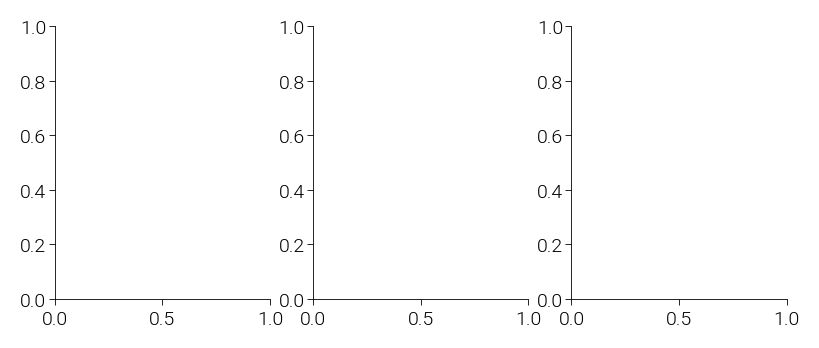

In [ ]:
GB = GasBoiler()
GB.T_w_tank = cu.C2K(60)
GB.x_ins = 0.05
GB.system_update()

# Create figure and axis - adjust figure size for vertical layout
nrows = 1
ncols = 3  # 가로 방향으로 3개의 subplot
fig, ax = plt.subplots(nrows, ncols, figsize=(dm.cm2in(12), dm.cm2in(4.5)), dpi=200, facecolor=None, edgecolor='k')

for idx in range(ncols):
    data = [entry['value'] for k,v in GB.exergy_balance.items() for sublist in list(v.values()) for entry in sublist]
    labels = [k for k,v in GB.exergy_balance.items()] 
    
    group_margin = 0.15  # margin between groups
    bar_margin = 0  # margin between bars
    bar_width = 0.2

    dN = len(data)  # number of data
    x_pos0 = np.array([i * (bar_margin + bar_width) for i in range(dN)])
    gl1 = [[2,1,2],[1,1,2],[2,1,2],[2,1,2]][idx]  # group
    gN = len(gl1)  # number of groups
    gl2 = np.cumsum(gl1)

    x_pos = x_pos0[:gl2[0]].tolist()
    for i in range(gN - 1):  # Add group_margin between arrays
        x_pos.extend((x_pos0[gl2[i]:gl2[i + 1]] + group_margin * (i + 1)).tolist())

    # Plot parameters
    sp_ratio = 0.5
    xmar = bar_width
    xmax = max(x_pos)
    xmin = min(x_pos)
    ymar = 0
    ymax = 3000
    ymin = 0
    yint = 200

    # Create vertical bars with different colors for each subplot
    bars = ax[idx].bar(x_pos, values, bar_width, 
                      color=[['dm.red6', 'dm.red5', 'dm.yellow6', 'dm.green6', 'dm.lime5'],
                            ['dm.red6', 'dm.yellow6', 'dm.green6', 'dm.lime5'],
                            ['dm.red6', 'dm.red5', 'dm.yellow6', 'dm.green6', 'dm.lime5']][idx])

    # Annotation
    ax[idx].annotate(f'{keys}', xy=(0.5, 1.1), 
                     xycoords='axes fraction', weight='bold', color='dm.gray9',
                     horizontalalignment='center', verticalalignment='bottom', 
                     fontsize=dm.fs(1.5))

    # Add value labels on top of each bar
    for bidx, bar in enumerate(bars):
        height = bar.get_height()
        ax[idx].text(bar.get_x() + bar.get_width() / 2., height + ymax / 150,
                    f'{height:.0f}', ha='center', va='bottom', fontsize=dm.fs(-2), fontweight=400)

    # Axes limits
    ax[idx].set_xlim(xmin - xmar, xmax + xmar)
    ax[idx].set_ylim(ymin - ymar, ymax + ymar)

    # Labels and ticks
    ax[idx].set_xticks(x_pos)
    ax[idx].set_xticklabels(labels, rotation=90, ha='center', fontsize=dm.fs(-1))
    ax[idx].set_yticks([])  # No y-ticks

    # Tick parameters
    ax[idx].tick_params(axis='x', direction='in', labelsize=dm.fs(-1),
                       which='major', length=0, width=0.5 * sp_ratio, pad=3)
    ax[idx].tick_params(axis='x', direction='in', labelsize=dm.fs(-2),
                       which='minor', length=0, width=0.25 * sp_ratio, pad=3)
    ax[idx].tick_params(axis='y', direction='in', labelsize=dm.fs(-2),
                       which='major', length=2, width=0.5 * sp_ratio, pad=3)
    ax[idx].tick_params(axis='y', direction='in', labelsize=dm.fs(-2),
                       which='minor', length=1, width=0.25 * sp_ratio, pad=3)

    # Minor ticks
    ax[idx].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax[idx].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

    # Spines
    for k in ['top', 'left', 'right']:  # Only keep bottom spine
        ax[idx].spines[k].set_visible(False)
    ax[idx].spines['bottom'].set_linewidth(0.5 * sp_ratio)
    ax[idx].spines['bottom'].set_color('k')

plt.subplots_adjust(hspace=0.6)
dm.simple_layout(fig, bbox=(0, 1, 0.1, .97), verbose=False)
img_stem = f'../figure/Gas_boiler_exergy_results(T_w_tank={cu.K2C(GB.T_w_tank):.0f})'
plt.savefig(f'{img_stem}.png', dpi=600)
dm.util.save_and_show(fig)

# Energy use, Primary energy use, CO2 emission, Exergy efficiency

In [4]:
1*0

0

In [3]:
EB.energy_balance['hot water tank']['in']

{'$E_{heater}$': 2742.842997710056, '$E_{w,sup,tank}$': 542.6296296296296}

In [20]:
EB  = ElectricBoiler()
GB  = GasBoiler()
HPB = HeatPumpBoiler()
EB.system_update()
GB.system_update()
HPB.system_update()

# Primary energy factor
PEF_elec = 2.75 
PEF_NG = 1.1

# CO2 emission factor
Wh2MJ = 10**6/(1*cu.h2s) # cu.h2s = 3600 s/h
C_to_CO2 = 44/12 # 탄소 배출량당 이산화탄소 배출량 분자량에 의한 환산계수 
CF_NG_ori = 15.281 # tC/TJ = kgC/GJ = gC/MJ

CF_elec = 0.4747 # tCO2/MWh = gCO2/Wh
CF_NG = (CF_NG_ori*C_to_CO2)/Wh2MJ # gCO2/Wh

# Energy use
energy_use = [
        EB.energy_balance['hot water tank']['in']['$E_{heater}$'],
        GB.energy_balance['combustion chamber']['in']['$E_{NG}$'],
        HPB.energy_balance['refrigerant loop']['in']['$E_{cmp}$'] + HPB.energy_balance['external unit']['in']['$E_{fan}$']
]

# Exergy use
exergy_use = [
        EB.exergy_balance['hot water tank']['in']['$E_{heater}$'],
        GB.exergy_balance['combustion chamber']['in']['$X_{NG}$'],
        HPB.exergy_balance['refrigerant loop']['in']['$E_{cmp}$'] + HPB.exergy_balance['external unit']['in']['$E_{fan}$']
]

# Primary energy use
primary_energy_use = [
        energy_use[0] * PEF_elec,
        energy_use[1] * PEF_NG,
        energy_use[2] * PEF_elec,
]

# CO2 emission
CO2_emission = [
        energy_use[0] * CF_elec, 
        energy_use[1] * CF_NG,
        energy_use[2] * CF_elec
]

eX_consum = [
        calculate_total_exergy_consumption(EB.exergy_balance),
        calculate_total_exergy_consumption(GB.exergy_balance),
        calculate_total_exergy_consumption(HPB.exergy_balance),
]

eX_efficiency = [
        EB.exergy_balance['mixing valve']['out']['$X_{w,serv}$']/exergy_use[0]*100,
        GB.exergy_balance['mixing valve']['out']['$X_{w,serv}$']/exergy_use[1]*100,
        HPB.exergy_balance['mixing valve']['out']['$X_{w,serv}$']/exergy_use[2]*100
]

# Create figure and axis - adjust figure size for vertical layout
nrows = 1
ncols = 4
fig, ax = plt.subplots(nrows, ncols, figsize=(dm.cm2in(16), dm.cm2in(3.5)), dpi=200, facecolor=None, edgecolor='k')

for ridx in range(nrows):
    for cidx in range(ncols):
        idx    = ridx * ncols + cidx
        data   = [energy_use, primary_energy_use, CO2_emission, eX_efficiency][idx]
        heading   = ['Energy use [W]', 'Primary energy use [W]', 'CO$_2$ emission [gCO$_2$/h]', 'Exergy efficiency [%]'][idx]
        labels = [['EB', 'GB', 'HPB'], # ['EB\n$(E_{heater}$)', 'GB\n$(E_{NG})$', 'HPB\n$(E_{fan} + E_{cmp})$']
                  ['EB', 'GB', 'HPB'],
                  ['EB', 'GB', 'HPB'],
                  ['EB', 'GB', 'HPB']][idx]

        group_margin = 0.15  # margin between groups
        bar_margin   = 0.1  # margin between bars
        bar_width    = 0.25

        dN     = len(data)  # number of data
        x_pos0 = np.array([i * (bar_margin + bar_width) for i in range(dN)]) # 바 margin과 bar width를 곱해서 그룹 마진이 없는 x_pos0에 저장
        gl1    = [[1,1,1],[1,1,1],[1,1,1],[1,1,1]][idx]  # group
        gN     = len(gl1)  # number of groups
        gl2    = np.cumsum(gl1)

        x_pos = x_pos0[:gl2[0]].tolist()
        for i in range(gN - 1):  # Add group_margin between arrays
            x_pos.extend((x_pos0[gl2[i]:gl2[i+1]] + group_margin * (i + 1)).tolist()) # 그룹 마진을 추가

        # Plot parameters
        sp_ratio = 0.5
        xmar = bar_width
        xmax = max(x_pos)
        xmin = min(x_pos)
        ymar = 0
        ymax = [9000, 9000, 1500, 30][idx]
        ymin = [0, 0, 0, 0][idx]
        yint = [3000, 3000, 500, 10][idx]

        # Create vertical bars
        bars = ax[idx].bar(x_pos, data, bar_width, color=[['dm.red7', 'dm.red5','dm.red3'],
                                                          ['dm.orange7', 'dm.orange5','dm.orange3'],
                                                          ['dm.green7', 'dm.green5','dm.green3'],
                                                          ['dm.grape7', 'dm.grape5','dm.grape3']][idx])

        # Annotation
        ax[idx].annotate(f'{heading}', xy=(0.5, 1.1), xycoords='axes fraction', color='dm.gray9',
                        horizontalalignment='center', verticalalignment='bottom', fontsize=dm.fs(0), fontweight=400)

        # Add value labels on top of each bar
        for bidx, bar in enumerate(bars):
            height = bar.get_height()
            if cidx < 3:
                ax[idx].text(bar.get_x() + bar.get_width() / 2., height + ymax / 150,
                        f'{height:.0f}', ha='center', va='bottom', fontsize=dm.fs(-2))
            elif cidx == 3:
                ax[idx].text(bar.get_x() + bar.get_width() / 2., height + ymax / 150,
                        f'{height:.1f}', ha='center', va='bottom', fontsize=dm.fs(-2))
            
        # Axes limits
        ax[idx].set_xlim(xmin - xmar, xmax + xmar)
        ax[idx].set_ylim(ymin - ymar, ymax + ymar)


        # Tick parameters
        ax[idx].tick_params(axis='x', direction='in', labelsize=dm.fs(-1.5),
                            which='major', length=0, width=0.5 * sp_ratio, pad=3)
        ax[idx].tick_params(axis='x', direction='in', labelsize=dm.fs(-1.5),
                            which='minor', length=0, width=0.25 * sp_ratio, pad=3)
        ax[idx].tick_params(axis='y', direction='in', labelsize=dm.fs(-1.5),
                            which='major', length=2, width=0.5 * sp_ratio, pad=3)
        ax[idx].tick_params(axis='y', direction='in', labelsize=dm.fs(-1.5),
                            which='minor', length=1, width=0.25 * sp_ratio, pad=3)

        # Labels and ticks
        ax[idx].set_xticks(x_pos)
        ax[idx].set_yticks(np.arange(ymin,ymax+yint,yint))  # No y-ticks
        ax[idx].set_xticklabels(labels, ha='center', fontsize=dm.fs(-1.5), fontweight='regular')
        ax[idx].set_yticklabels(np.arange(ymin,ymax+yint,yint), fontsize=dm.fs(-1.5), fontweight='regular')
        
        # Minor ticks
        ax[idx].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
        ax[idx].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

        # Spines
        for k in ['top','right']:  # Only keep bottom spine
            ax[idx].spines[k].set_visible(False)
        ax[0].spines['bottom'].set_linewidth(0.5 * sp_ratio)
        ax[0].spines['bottom'].set_color('k')

plt.subplots_adjust(wspace=0.3)
dm.simple_layout(fig, bbox=(0.01,1,0.0,.945), verbose=False)
# img_stem = f'../figure/heat_pump_boiler_exergy_results'
# plt.savefig(f'{img_stem}.png', dpi=600)
dm.util.save_and_show(fig)


In [ ]:
EB  = ElectricBoiler()
GB  = GasBoiler()
HPB = HeatPumpBoiler()
EB.system_update()
GB.system_update()
HPB.system_update()

# Primary energy factor
PEF_elec = 2.75 
PEF_NG = 1.1

# CO2 emission factor
Wh2MJ = 10**6/(1*cu.h2s) # cu.h2s = 3600 s/h
C_to_CO2 = 44/12 # 탄소 배출량당 이산화탄소 배출량 분자량에 의한 환산계수 
CF_NG_ori = 15.281 # tC/TJ = kgC/GJ = gC/MJ

CF_elec = 0.4747 # tCO2/MWh = gCO2/Wh
CF_NG = (CF_NG_ori*C_to_CO2)/Wh2MJ # gCO2/Wh

# Energy use
energy_use = [
    GB.energy_balance['combustion chamber']['in']['$E_{NG}$'],
    HPB.energy_balance['refrigerant loop']['in']['$E_{cmp}$'] + HPB.energy_balance['external unit']['in']['$E_{fan}$']
]

# Exergy use
exergy_use = [
    GB.exergy_balance['combustion chamber']['in']['$X_{NG}$'],
    HPB.exergy_balance['refrigerant loop']['in']['$E_{cmp}$'] + HPB.exergy_balance['external unit']['in']['$E_{fan}$']
]

# Primary energy use
primary_energy_use = [
    energy_use[0] * PEF_NG,
    energy_use[1] * PEF_elec,
]

# CO2 emission
CO2_emission = [
    energy_use[0] * CF_NG,
    energy_use[1] * CF_elec
]

eX_consum = [
    calculate_total_exergy_consumption(GB.exergy_balance),
    calculate_total_exergy_consumption(HPB.exergy_balance),
]

eX_efficiency = [
    GB.exergy_balance['mixing valve']['out']['$X_{w,serv}$']/exergy_use[0]*100,
    HPB.exergy_balance['mixing valve']['out']['$X_{w,serv}$']/exergy_use[1]*100
]

# Create figure and axis - adjust figure size for vertical layout
nrows = 1
ncols = 4
fig, ax = plt.subplots(nrows, ncols, figsize=(dm.cm2in(12), dm.cm2in(3.5)), dpi=200, facecolor=None, edgecolor='k')

for ridx in range(nrows):
    for cidx in range(ncols):
        idx    = ridx * ncols + cidx
        data   = [energy_use, primary_energy_use, CO2_emission, eX_efficiency][idx]
        heading   = ['Energy use [W]', 'Primary energy use [W]', 'CO$_2$ emission [gCO$_2$/h]', 'Exergy efficiency [%]'][idx]
        labels = [['GB', 'HPB'], 
            ['GB', 'HPB'],
            ['GB', 'HPB'],
            ['GB', 'HPB']][idx]

        group_margin = 0  # margin between groups
        bar_margin   = 0.05  # margin between bars
        bar_width    = 0.25

        dN     = len(data)  # number of data
        x_pos0 = np.array([i * (bar_margin + bar_width) for i in range(dN)]) # 바 margin과 bar width를 곱해서 그룹 마진이 없는 x_pos0에 저장
        gl1    = [[1,1],[1,1],[1,1],[1,1]][idx]  # group
        gN     = len(gl1)  # number of groups
        gl2    = np.cumsum(gl1)

        x_pos = x_pos0[:gl2[0]].tolist()
        for i in range(gN - 1):  # Add group_margin between arrays
            x_pos.extend((x_pos0[gl2[i]:gl2[i+1]] + group_margin * (i + 1)).tolist()) # 그룹 마진을 추가

        # Plot parameters
        sp_ratio = 0.5
        xmar = bar_width
        xmax = max(x_pos)
        xmin = min(x_pos)
        ymar = 0
        ymax = [4000, 4000, 800, 30][idx]
        ymin = [0, 0, 0, 0][idx]
        yint = [1000, 1000, 200, 10][idx]

        # Create vertical bars
        bars = ax[idx].bar(x_pos, data, bar_width, color=[['dm.red7', 'dm.red5'],
                                ['dm.orange7', 'dm.orange5'],
                                ['dm.green7', 'dm.green5'],
                                ['dm.grape7', 'dm.grape5']][idx])

        # Annotation
        ax[idx].annotate(f'{heading}', xy=(0.5, 1.1), xycoords='axes fraction', color='dm.gray9',
                horizontalalignment='center', verticalalignment='bottom', fontsize=dm.fs(-1), fontweight=400)

        # Add value labels on top of each bar
        for bidx, bar in enumerate(bars):
            height = bar.get_height()
            if cidx < 3:
                ax[idx].text(bar.get_x() + bar.get_width() / 2., height + ymax / 150,
                f'{height:.0f}', ha='center', va='bottom', fontsize=dm.fs(-2), fontweight = 300)
            elif cidx == 3:
                ax[idx].text(bar.get_x() + bar.get_width() / 2., height + ymax / 150,
                f'{height:.1f}', ha='center', va='bottom', fontsize=dm.fs(-2), fontweight = 300)
            
        # Axes limits
        ax[idx].set_xlim(xmin - xmar, xmax + xmar)
        ax[idx].set_ylim(ymin - ymar, ymax + ymar)


        # Tick parameters
        ax[idx].tick_params(axis='x', direction='in', labelsize=dm.fs(-1.5),
                    which='major', length=0, width=0.5 * sp_ratio, pad=3)
        ax[idx].tick_params(axis='x', direction='in', labelsize=dm.fs(-1.5),
                    which='minor', length=0, width=0.25 * sp_ratio, pad=3)
        ax[idx].tick_params(axis='y', direction='out', labelsize=dm.fs(-1.5),
                    which='major', length=2, width=0.5 * sp_ratio, pad=3)
        ax[idx].tick_params(axis='y', direction='out', labelsize=dm.fs(-1.5),
                    which='minor', length=0, width=0.25 * sp_ratio, pad=3)

        # Labels and ticks
        ax[idx].set_xticks(x_pos)
        ax[idx].set_yticks(np.arange(ymin,ymax+yint,yint))  # No y-ticks
        ax[idx].set_xticklabels(labels, ha='center', fontsize=dm.fs(-1.5), fontweight=300)
        ax[idx].set_yticklabels(np.arange(ymin,ymax+yint,yint), fontsize=dm.fs(-1.5), fontweight= 300)
        
        # Minor ticks
        ax[idx].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
        ax[idx].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

        # Spines
        for k in ['top','right']:  # Only keep bottom spine
            ax[idx].spines[k].set_visible(False)
        ax[0].spines['bottom'].set_linewidth(0.5 * sp_ratio)
        ax[0].spines['bottom'].set_color('k')

plt.subplots_adjust(wspace=0.4)
dm.simple_layout(fig, bbox=(0.01,1,0.0,1), verbose=False)
img_stem = r'C:\betlab\00 Papers, Conferences\01 Conferences\2025\AIK 춘계학술발표\DHW exergy analysis_HB\figure\GB&HPB_results'
plt.savefig(f'{img_stem}.png', dpi=600)
dm.util.save_and_show(fig)


: 

In [ ]:
EB.energy_balance['hot water tank']['in'].values()

dict_values([2742.842997710056, 542.6296296296296])

# Casacade plot

## EB

In [30]:
EB = ElectricBoiler()
EB.system_update()

# sub system names
sub_system = list(EB.exergy_balance)

## Exergy values ========================================
values, labels, flows = [], [], [] 

for sub in sub_system:
    for flow in ['in', 'consumed', 'out']:
        flows.extend([flow for _ in range(len(EB.exergy_balance[sub][flow]))])
        values.extend([dictionary['value'] if flow == "in" else -dictionary['value'] for dictionary in EB.exergy_balance[sub][flow]])
        labels.extend([dictionary['symbol'] for dictionary in EB.exergy_balance[sub][flow]])
values[-1] = abs(values[-1])

# 중복제거    
new_values, new_labels, new_flows = [], [], []
for idx, (target, label, flow) in enumerate(zip(values, labels, flows)):
    if any(abs(val) == abs(target) for val in new_values):  # 절댓값만 비교
        matching_indices = [i for i, val in enumerate(new_values) if abs(val) == abs(target)]
        del new_values[matching_indices[0]]
        del new_labels[matching_indices[0]]
        del new_flows[matching_indices[0]]
    else:
        new_values.append(target)
        new_labels.append(label)
        new_flows.append(flow)

cum_values = np.cumsum(new_values)

# Set up the plot
fig, ax = plt.subplots(figsize=(dm.cm2in(10), dm.cm2in(5)))

# Common settings
bar_width = 0.4
y_max = 3000
x_padding = 0.4
line_thickness = 0.1
text_padding = y_max * 0.01

# Function to draw connecting lines
def draw_waterfall_lines(ax, x, cum_values, line_thickness):
    for i in range(1, len(x)):
        start = cum_values[i-1]
        ax.plot([x[i-1]-bar_width/2, x[i]+bar_width/2], [start, start], color='dm.gray6', linestyle='-', linewidth=line_thickness)

#  plot
dN = len(new_values)
x = np.arange(dN)
colors = ["tw.blue:500" if val > 0 else "tw.lime:500" for val in new_values]

# Plot bars for 
for i in range(len(x)):
    if i == 0 or i == len(x) - 1: # 첫번째와 마지막 bar는 cumvalue를 bottom으로 설정하지 않음 -> 기본 바 형태로 그림
        ax.bar(x[i], new_values[i], bar_width, color=colors[i])
    else:
        ax.bar(x[i], new_values[i], bar_width, bottom=cum_values[i-1], color=colors[i]) # cumvalue를 bottom으로 설정하여 waterfall 형태로 그림

# Draw connecting lines for 
draw_waterfall_lines(ax, x, cum_values, line_thickness)

# Axis settings
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.set_yticks([])
ax.set_ylim(0, y_max)

# Set x-axis labels and limits
ax.set_xticks(x)
ax.set_xticklabels(new_labels, ha='center', fontsize=dm.fs(0.5), color = 'tw.gray:800')
ax.set_xlim(-x_padding, dN - 1 + x_padding)

# Spines settings
for k in ['top', 'right', 'left']:  # Only keep bottom spine
    ax.spines[k].set_visible(False)


# Add bar values as text
for i, value in enumerate(new_values):
    flow = new_flows[i]
    if i == 0 or i == dN - 1:
        height = new_values[i]
        va = 'bottom'
        y_pos = height + text_padding
    else:
        height = cum_values[i]
        va = 'bottom' if flow == 'in' else 'top'
        y_pos = height + text_padding if flow == 'in' else height - text_padding
    
    ax.text(i, y_pos, f'{value:.1f}', ha='center', va=va, fontsize=dm.fs(-0.5), weight=400, color = 'tw.gray:800')

dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=(0, 1, 0, 1), verbose=False)
# fig_name = 'EB_waterfall'
# fig.savefig(f'../figure/{fig_name}.png', dpi=600)

TypeError: string indices must be integers, not 'str'

## GB

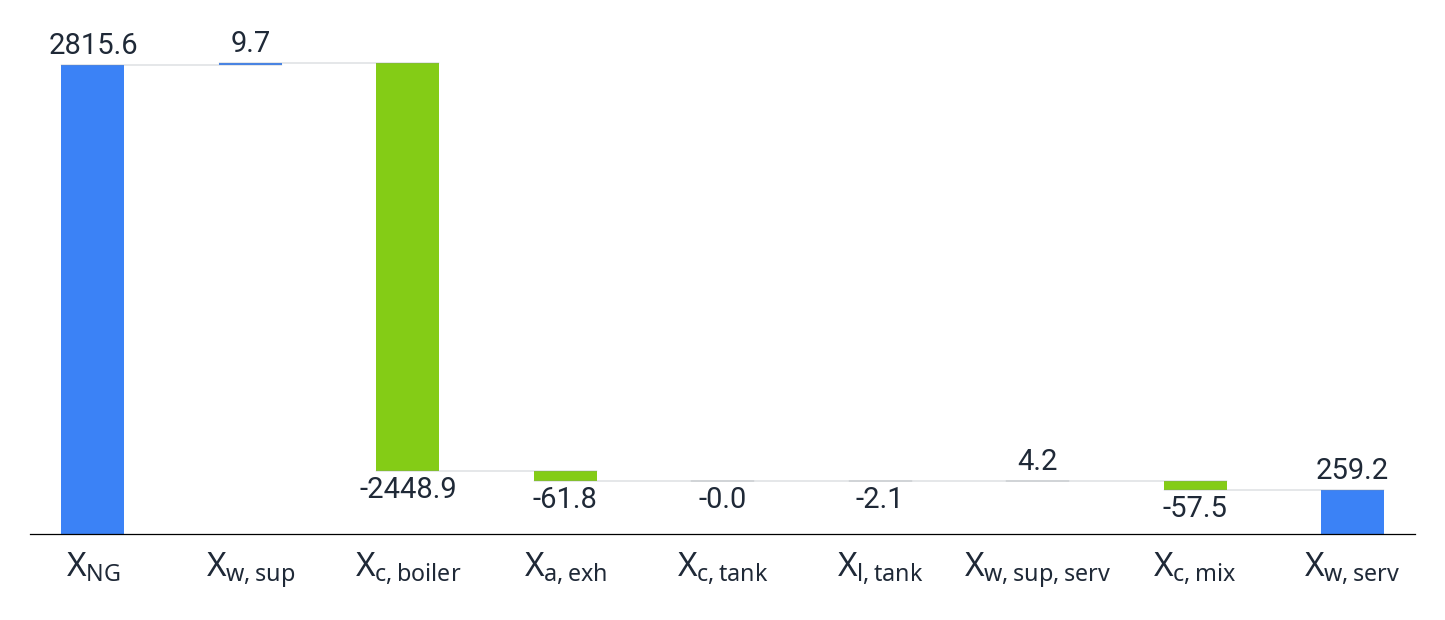

In [ ]:
GB = GasBoiler()
GB.system_update()

# sub system names
sub_system = list(GB.exergy_balance)

## Exergy values ========================================
values, labels, flows = [], [], [] 

for sub in sub_system:
    for flow in ['in', 'consumed', 'out']:
        flows.extend([flow for _ in range(len(GB.exergy_balance[sub][flow]))])
        values.extend([dictionary['value'] if flow == "in" else -dictionary['value'] for dictionary in GB.exergy_balance[sub][flow]])
        labels.extend([dictionary['symbol'] for dictionary in GB.exergy_balance[sub][flow]])
values[-1] = abs(values[-1])

# 중복제거    
new_values, new_labels, new_flows = [], [], []
for idx, (target, label, flow) in enumerate(zip(values, labels, flows)):
    if any(abs(val) == abs(target) for val in new_values):  # 절댓값만 비교
        matching_indices = [i for i, val in enumerate(new_values) if abs(val) == abs(target)]
        del new_values[matching_indices[0]]
        del new_labels[matching_indices[0]]
        del new_flows[matching_indices[0]]
    else:
        new_values.append(target)
        new_labels.append(label)
        new_flows.append(flow)

cum_values = np.cumsum(new_values)

# Set up the plot
fig, ax = plt.subplots(figsize=(dm.cm2in(12), dm.cm2in(5)))

# Common settings
bar_width = 0.4
y_max = 3000
x_padding = 0.4
line_thickness = 0.1
text_padding = y_max * 0.01

# Function to draw connecting lines
def draw_waterfall_lines(ax, x, cum_values, line_thickness):
    for i in range(1, len(x)):
        start = cum_values[i-1]
        ax.plot([x[i-1]-bar_width/2, x[i]+bar_width/2], [start, start], color='dm.gray6', linestyle='-', linewidth=line_thickness)

#  plot
dN = len(new_values)
x = np.arange(dN)
colors = ["tw.blue:500" if val > 0 else "tw.lime:500" for val in new_values]

# Plot bars for 
for i in range(len(x)):
    if i == 0 or i == len(x) - 1: # 첫번째와 마지막 bar는 cumvalue를 bottom으로 설정하지 않음 -> 기본 바 형태로 그림
        ax.bar(x[i], new_values[i], bar_width, color=colors[i])
    else:
        ax.bar(x[i], new_values[i], bar_width, bottom=cum_values[i-1], color=colors[i]) # cumvalue를 bottom으로 설정하여 waterfall 형태로 그림

# Draw connecting lines for 
draw_waterfall_lines(ax, x, cum_values, line_thickness)

# Axis settings
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.set_yticks([])
ax.set_ylim(0, y_max)

# Set x-axis labels and limits
ax.set_xticks(x)
ax.set_xticklabels(new_labels, ha='center', fontsize=dm.fs(0.5), color = 'tw.gray:800')
ax.set_xlim(-x_padding, dN - 1 + x_padding)

# Spines settings
for k in ['top', 'right', 'left']:  # Only keep bottom spine
    ax.spines[k].set_visible(False)


# Add bar values as text
for i, value in enumerate(new_values):
    flow = new_flows[i]
    if i == 0 or i == dN - 1:
        height = new_values[i]
        va = 'bottom'
        y_pos = height + text_padding
    else:
        height = cum_values[i]
        va = 'bottom' if flow == 'in' else 'top'
        y_pos = height + text_padding if flow == 'in' else height - text_padding
    
    ax.text(i, y_pos, f'{value:.1f}', ha='center', va=va, fontsize=dm.fs(-0.5), weight=400, color = 'tw.gray:800')

dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=(0, 1, 0, 1), verbose=False)
fig_name = 'GB_waterfall'
fig.savefig(f'../figure/{fig_name}.png', dpi=600)

## HPB

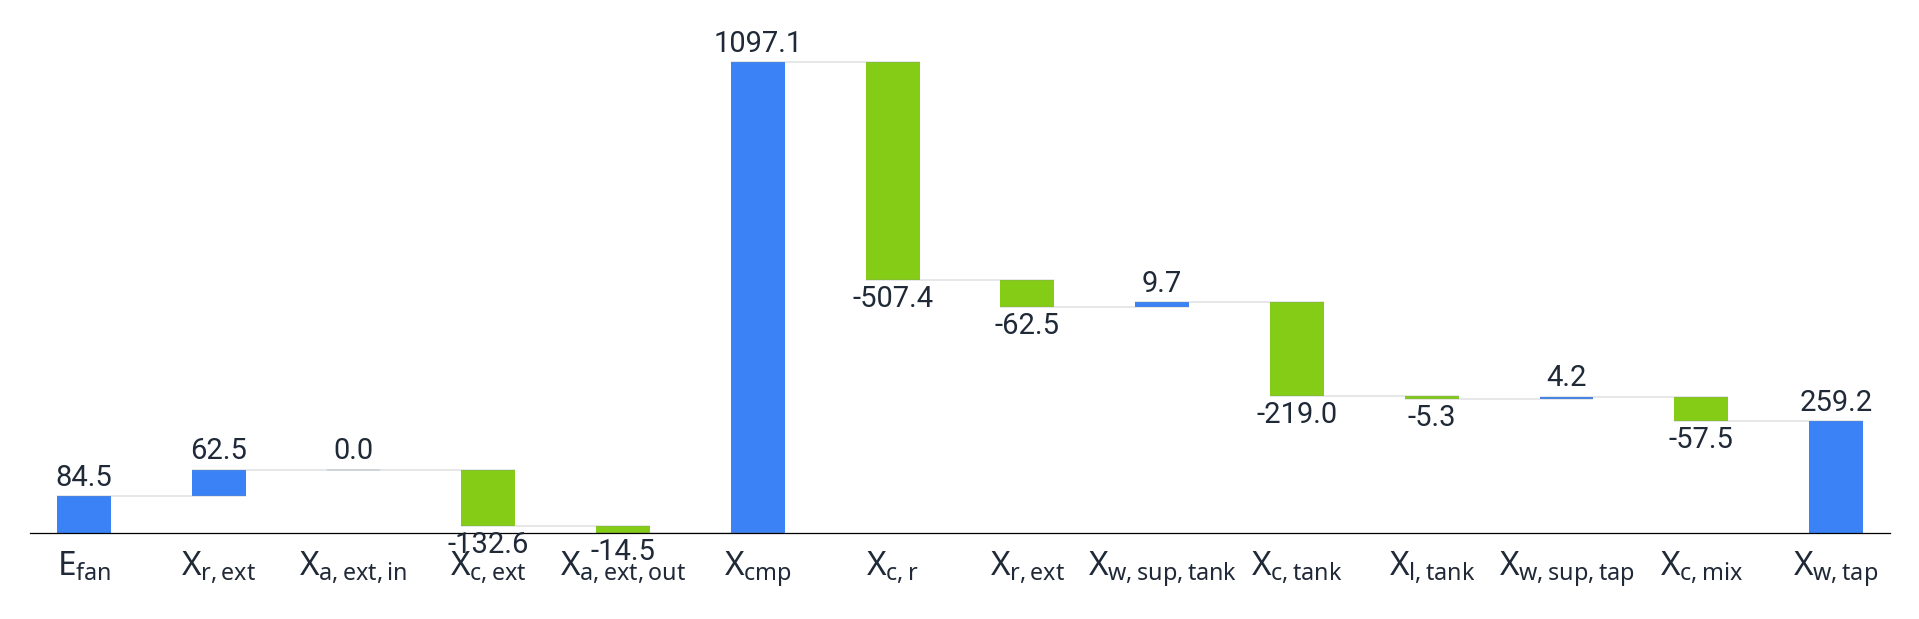

In [ ]:
HPB = HeatPumpBoiler()
HPB.system_update()

# sub system names
sub_system = list(HPB.exergy_balance)

## Exergy values ========================================
values, labels, flows = [], [], [] 

for sub in sub_system:
    for flow in ['in', 'consumed', 'out']:
        flows.extend([flow for _ in range(len(HPB.exergy_balance[sub][flow]))])
        values.extend([dictionary['value'] if flow == "in" else -dictionary['value'] for dictionary in HPB.exergy_balance[sub][flow]])
        labels.extend([dictionary['symbol'] for dictionary in HPB.exergy_balance[sub][flow]])
values[-1] = abs(values[-1])

# 중복제거    
new_values, new_labels, new_flows = [], [], []
for idx, (target, label, flow) in enumerate(zip(values, labels, flows)):
    if any(abs(val) == abs(target) for val in new_values):  # 절댓값만 비교
        matching_indices = [i for i, val in enumerate(new_values) if abs(val) == abs(target)]
        if label =="$X_{r,ext}$": # 예외처리
            new_values.append(target)
            new_labels.append(label)
            new_flows.append(flow)
        else:
            del new_values[matching_indices[0]]
            del new_labels[matching_indices[0]]
            del new_flows[matching_indices[0]]
    else:
        new_values.append(target)
        new_labels.append(label)
        new_flows.append(flow)
        

cum_values = np.cumsum(new_values)

# Set up the plot
fig, ax = plt.subplots(figsize=(dm.cm2in(16), dm.cm2in(5)))

# Common settings
bar_width = 0.4
y_max = 1100
x_padding = 0.4
line_thickness = 0.1
text_padding = y_max * 0.01

# Function to draw connecting lines
def draw_waterfall_lines(ax, x, cum_values, line_thickness):
    for i in range(1, len(x)):
        start = cum_values[i-1]
        ax.plot([x[i-1]-bar_width/2, x[i]+bar_width/2], [start, start], color='dm.gray6', linestyle='-', linewidth=line_thickness)

#  plot
dN = len(new_values)
x = np.arange(dN)
colors = ["tw.blue:500" if val > 0 else "tw.lime:500" for val in new_values]

# Plot bars for 
for i in range(len(x)):
    if i == 0 or i == len(x) - 1: # 첫번째와 마지막 bar는 cumvalue를 bottom으로 설정하지 않음 -> 기본 바 형태로 그림
        ax.bar(x[i], new_values[i], bar_width, color=colors[i])
    else:
        ax.bar(x[i], new_values[i], bar_width, bottom=cum_values[i-1], color=colors[i]) # cumvalue를 bottom으로 설정하여 waterfall 형태로 그림

# Draw connecting lines for 
draw_waterfall_lines(ax, x, cum_values, line_thickness)

# Axis settings
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.set_yticks([])
ax.set_ylim(0, y_max)

# Set x-axis labels and limits
ax.set_xticks(x)
ax.set_xticklabels(new_labels, ha='center', fontsize=dm.fs(0.5), color = 'tw.gray:800')
ax.set_xlim(-x_padding, dN - 1 + x_padding)

# Spines settings
for k in ['top', 'right', 'left']:  # Only keep bottom spine
    ax.spines[k].set_visible(False)


# Add bar values as text
for i, value in enumerate(new_values):
    flow = new_flows[i]
    if i == 0 or i == dN - 1:
        height = new_values[i]
        va = 'bottom'
        y_pos = height + text_padding
    else:
        height = cum_values[i]
        va = 'bottom' if flow == 'in' else 'top'
        y_pos = height + text_padding if flow == 'in' else height - text_padding
    
    ax.text(i, y_pos, f'{value:.1f}', ha='center', va=va, fontsize=dm.fs(-0.5), weight=400, color = 'tw.gray:800')

dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=(0, 1, 0, 1), verbose=False)
fig_name = 'HPB_waterfall'
fig.savefig(f'../figure/{fig_name}.png', dpi=600)

In [32]:
HPB = HeatPumpBoiler()
HPB.system_update()
# print_balance(HPB.exergy_balance)

E_cmp = HPB.energy_balance['refrigerant loop']['in']['$E_{cmp}$']
E_fan = HPB.energy_balance['external unit']['in']['$E_{fan}$']
E_r_tank = HPB.energy_balance['refrigerant loop']['out']['$E_{r,tank}$']

X_w_serv = HPB.exergy_balance['mixing valve']['out']['$X_{w,serv}$']
X_w_tank = HPB.exergy_balance['mixing valve']['in']['$X_{w,tank}$']
X_c_mix = HPB.exergy_balance['mixing valve']['consumed']['$X_{c,mix}$']
X_r_ext = HPB.exergy_balance['refrigerant loop']['out']['$X_{r,ext}$']

GB = GasBoiler()
GB.T_w_tank = cu.C2K(50)
GB.system_update()
print_balance(GB.exergy_balance)
X_l_exh = GB.exergy_balance['combustion chamber']['out']['$X_{a,exh}$']
E_NG = GB.energy_balance['combustion chamber']['in']['$E_{NG}$']

ratio = X_c_mix / X_w_tank
print(ratio)



COMBUSTION CHAMBER EXERGY BALANCE:================

IN ENTRIES:
$X_{NG}$: 2813.61 [W]
$X_{w,sup}$: 12.12 [W]

OUT ENTRIES:
$X_{w,comb,out}$: 278.56 [W]
$X_{a,exh}$: 61.72 [W]

CONSUMED ENTRIES:
$X_{c,boiler}$: 2485.45 [W]


HOT WATER TANK EXERGY BALANCE:====================

IN ENTRIES:
$X_{w,comb,out}$: 278.56 [W]

OUT ENTRIES:
$X_{w,tank}$: 277.06 [W]
$X_{l,tank}$: 1.5 [W]

CONSUMED ENTRIES:
$X_{c,tank}$: 0.0 [W]


MIXING VALVE EXERGY BALANCE:======================

IN ENTRIES:
$X_{w,tank}$: 277.06 [W]
$X_{w,sup,serv}$: 1.73 [W]

OUT ENTRIES:
$X_{w,serv}$: 259.23 [W]

CONSUMED ENTRIES:
$X_{c,mix}$: 19.56 [W]
0.18392128697106713


# Fan & Pump test

In [ ]:
Fan().show_graph()


========== Flow Rate vs Pressure ==========
fan 1: -23.0405x³ + 107.9306x² + -113.5508x + 170.8994
fan 2: -24.8299x³ + 68.9528x² + 3.6020x + 117.3624

========== Flow Rate vs Efficiency ==========
fan 1: -0.0333x³ + 0.0500x² + 0.2285x + 0.2786
fan 2: -0.0340x³ + -0.1126x² + 0.5772x + 0.1937


# Monte Carlo simulation

## EB

In [ ]:
# 시뮬레이션 반복 횟수
num_simulations = 5000

# 확률 분포 정의
x_ins_samples     = np.random.normal(loc=0.10, scale=0.005, size=num_simulations)  # 단열 두께 (m) - 정규 분포
V_tank_samples    = np.random.uniform(0.08, 0.12, size=num_simulations)  # 탱크 용적 (m³) - 균등 분포
water_use_samples = triang.rvs(c=0.5, loc=0.15, scale=0.1, size=num_simulations)  # 물 사용량 (m³/day) - 삼각 분포
h_co_samples      = gamma.rvs(a=2, scale=1, size=num_simulations)  # 대류 열전달 계수 (W/m²K) - 감마 분포

distribution = {'x_ins': 
                    {'val': x_ins_samples, 'xlabel': 'Insulation Thickness [m]', 'color': 'tw.blue:500'},
                'V_tank':
                    {'val': V_tank_samples, 'xlabel': 'Tank Volume [m³]', 'color': 'tw.orange:500'},
                'water_use':
                    {'val': water_use_samples, 'xlabel': 'Water Use [m³/day]', 'color': 'tw.green:500'},
                'h_co':
                    {'val': h_co_samples, 'xlabel': 'Convective Heat Transfer Coefficient [W/m²K]', 'color': 'tw.red:500'}}

# 엑서지 효율 저장 리스트
exergy_efficiency = []

# 몬테카를로 시뮬레이션 실행
for i in range(num_simulations):
    # ElectricBoiler 객체 생성
    boiler = ElectricBoiler()

    # 확률 변수 할당
    boiler.x_ins = x_ins_samples[i]       # 단열 두께
    boiler.V_tank = V_tank_samples[i]     # 탱크 용적
    boiler.water_use_in_a_day = water_use_samples[i]  # 하루 물 사용량

    # 시스템 업데이트 수행
    boiler.system_update()

    # 엑서지 효율 계산
    X_w_tank = boiler.exergy_balance["hot water tank"]["out"]["$X_{w,tank}$"]
    X_w_serv = boiler.exergy_balance["mixing valve"]["out"]["$X_{w,serv}$"]
    X_l_tank = boiler.exergy_balance["hot water tank"]["out"]["$X_{l,tank}$"]
    E_heater = boiler.exergy_balance["hot water tank"]["in"]["$E_{heater}$"]
    X_w_sup_tank = boiler.exergy_balance["hot water tank"]["in"]["$X_{w,sup,tank}$"]

    eta_exergy = X_w_serv / E_heater
    exergy_efficiency.append(eta_exergy)

# 데이터 시각화
nrows = 1
ncols = 1

xmin, xmax, xint, xmar = 9.3, 9.6, 0.1, 0
ymin, ymax, yint, ymar = 0, 40, 10, 0

fig, ax = plt.subplots(nrows, ncols, figsize=(dm.cm2in(10), dm.cm2in(6)), dpi=600)
for ridx in range(nrows):
    for cidx in range(ncols):
        idx = ridx * ncols + cidx

        # Plot histogram
        sns.kdeplot(np.array(exergy_efficiency) * 100, ax=ax, color='tw.indigo:700', fill=True, linewidth=0.75)

        # tick limits 
        ax.set_xlim(xmin - xmar, xmax + xmar)
        ax.set_ylim(ymin - ymar, ymax + ymar)
        
        # set ticks
        ax.set_xticks(np.arange(xmin, xmax + xint, xint))
        ax.set_yticks(np.arange(ymin, ymax + yint, yint))
        
        # print x, y range
        print(f"x range: {min(exergy_efficiency)*100:.2f} ~ {max(exergy_efficiency)*100:.2f}")
        # print(f"y max: {max_frequency}")
        

plt.xlabel("Exergy Efficiency [%]", fontsize=dm.fs(0), fontweight=300 )
plt.ylabel("Frequency", fontsize=dm.fs(0), fontweight=300)
plt.title("Exergy Efficiency Distribution from Monte Carlo Simulation", fontsize=dm.fs(0), fontweight=400)
dm.simple_layout(fig, bbox=(0, 1, 0.01, 1), verbose=False)
dm.util.save_and_show(fig)


x range: 9.40 ~ 9.49


In [ ]:

# 입력 확률 분포 시각화
nrows = 1
ncols = len(distribution)

fig, axes = plt.subplots(nrows, ncols, figsize=(dm.cm2in(21), dm.cm2in(4)), dpi=600)

for idx, (key, dist) in enumerate(distribution.items()):
    sns.kdeplot(dist['val'], ax=axes[idx], fill=True, color=dist['color'], linewidth=0.75)
    axes[idx].set_xlabel(dist['xlabel'])
    axes[0].set_ylabel("Density")

plt.subplots_adjust(wspace=0.3)
dm.simple_layout(fig, bbox=(0, 1, 0, 1), verbose=False)
dm.util.save_and_show(fig,)


In [3]:
np.arange(0, 1.1, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
Elec_boiler = ElectricBoiler()
Elec_boiler.T_w_tank = cu.C2K(70)
Elec_boiler.system_update()

# Create figure and axis - adjust figure size for vertical layout
nrows = 1
ncols = 2
fig, ax = plt.subplots(nrows, ncols, figsize=(dm.cm2in(8), dm.cm2in(4.5)), dpi=200, facecolor=None, edgecolor='k')

for idx in range(ncols):
    data = list(Elec_boiler.exergy_balance.values())[idx]
    keys = list(Elec_boiler.exergy_balance.keys())[idx]
    values = list(data.values())
    labels = list(data.keys())

    group_margin = 0.3  # margin between groups
    bar_margin = 0.1  # margin between bars
    bar_width = 0.2

    dN = len(data)  # number of data
    x_pos0 = np.array([i * (bar_margin + bar_width) for i in range(dN)])
    gl1 = [[2, 1, 2], [2, 1, 1], [2, 1, 2], [2, 1, 2]][idx]  # group
    gN = len(gl1)  # number of groups
    gl2 = np.cumsum(gl1)

    x_pos = x_pos0[:gl2[0]].tolist()
    for i in range(gN - 1):  # Add group_margin between arrays
        x_pos.extend((x_pos0[gl2[i]:gl2[i + 1]] + group_margin * (i + 1)).tolist())

    # Plot parameters
    sp_ratio = 0.5
    xmar = bar_width
    xmax = max(x_pos)
    xmin = min(x_pos)
    ymar = 0
    ymax = 3000
    ymin = 0
    yint = 200

    # Create vertical bars
    bars = ax[idx].bar(x_pos, values, bar_width, color=['dm.red6', 'dm.red5', 'dm.yellow6', 'dm.green6', 'dm.lime5'])

    # Annotation
    ax[idx].annotate(f'{keys}', xy=(0.5, 1.1), xycoords='axes fraction', color='dm.gray9',fontweight=500,
                      horizontalalignment='center', verticalalignment='bottom', fontsize=dm.fs(1.5))

    # Add value labels on top of each bar
    for bidx, bar in enumerate(bars):
        height = bar.get_height()
        ax[idx].text(bar.get_x() + bar.get_width() / 2., height + ymax / 150,
                     f'{height:.0f}', ha='center', va='bottom', fontsize=dm.fs(-3), fontweight=400)

    # Axes limits
    ax[idx].set_xlim(xmin - xmar, xmax + xmar)
    ax[idx].set_ylim(ymin - ymar, ymax + ymar)

    # Labels and ticks
    ax[idx].set_xticks(x_pos)
    ax[idx].set_xticklabels(labels, rotation=90, ha='center', fontsize=dm.fs(-1))
    ax[idx].set_yticks([])  # No y-ticks

    # Tick parameters
    ax[idx].tick_params(axis='x', direction='in', labelsize=dm.fs(-1),
                        which='major', length=0, width=0.5 * sp_ratio, pad=300)
    ax[idx].tick_params(axis='x', direction='in', labelsize=dm.fs(-2),
                        which='minor', length=0, width=0.25 * sp_ratio, pad=3)
    ax[idx].tick_params(axis='y', direction='in', labelsize=dm.fs(-2),
                        which='major', length=2, width=0.5 * sp_ratio, pad=3)
    ax[idx].tick_params(axis='y', direction='in', labelsize=dm.fs(-2),
                        which='minor', length=1, width=0.25 * sp_ratio, pad=3)

    # Minor ticks
    ax[idx].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax[idx].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

    # Spines
    for k in ['top', 'left', 'right']:  # Only keep bottom spine
        ax[idx].spines[k].set_visible(False)
    ax[idx].spines['bottom'].set_linewidth(0.5 * sp_ratio)
    ax[idx].spines['bottom'].set_color('k')

plt.subplots_adjust(hspace=0.6)
dm.simple_layout(fig, bbox=(0, 1, 0.2, .95), verbose=False)
img_stem = f'../figure/ElectricBoiler_exergy_results(T_w_tank={cu.K2C(Elec_boiler.T_w_tank):.0f})'
plt.savefig(f'{img_stem}.png', dpi=600)
dm.util.save_and_show(fig)


# Test

In [25]:
# u 값 정의 (0.01부터 10까지의 범위)
u_values = np.linspace(0.01, 10, 500)

# 함수 값 계산
y_values = np.exp(-u_values) / u_values

# 그래프 그리기
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(dm.cm2in(16), dm.cm2in(5)), dpi=600)

# 첫 번째 그래프: x의 범위 0부터 10까지
ax1.plot(u_values, y_values, label=r'$\frac{e^{-u}}{u}$', color='dm.blue6', linewidth = 0.75)
ax1.set_xlabel('u', fontsize=dm.fs(0))
ax1.set_ylabel(r'$\frac{e^{-u}}{u}$', fontsize=dm.fs(0))
ax1.set_title('Graph of $e^{-u} / u$ (0 to 10)', fontsize=dm.fs(0))
ax1.legend(fontsize=dm.fs(-1))
ax1.grid()

# 두 번째 그래프: x의 범위 0부터 1까지
ax2.plot(u_values, y_values, label=r'$\frac{e^{-u}}{u}$', color='dm.blue6', linewidth = 0.75)
ax2.set_xlim(0, 1)
ax2.set_xlabel('u', fontsize=dm.fs(0))
ax2.set_ylabel(r'$\frac{e^{-u}}{u}$', fontsize=dm.fs(0))
ax2.set_title('Graph of $e^{-u} / u$ (0 to 1)', fontsize=dm.fs(0))
ax2.legend(fontsize=dm.fs(-1))
ax2.grid()

# 그래프 표시+
dm.simple_layout(fig, bbox=(0.0, 1, 0.02, 1), verbose=False)
dm.util.save_and_show(fig)
fig_name = 'exp_u_over_u'
fig.savefig(f'C:/Users/habin/OneDrive/Habin/03. Document/수업자료 & 과제/25-1/재생에너지시스템의설계/figure/{fig_name}.svg')

In [ ]:
@dataclass
class Fan:
    def __post_init__(self): 
        # Parameters
        self.fan1 = {
            'flow rate'  : [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.5, 3.0], # [m3/s]
            'pressure'   : [140, 136, 137, 147, 163, 178, 182, 190, 198, 181], # [Pa]
            'efficiency' : [0.43, 0.48, 0.52, 0.55, 0.60, 0.65, 0.68, 0.66, 0.63, 0.52], # [-]
        }
        self.fan2 = {
            'flow rate'  : [0.5, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.5], # [m3/s]
            'pressure'   : [137, 138, 143, 168, 182, 191, 198, 200, 201, 170], # [Pa]
            'efficiency' : [0.45, 0.49, 0.57, 0.62, 0.67, 0.69, 0.68, 0.67, 0.63, 0.40], # [-]
        }
        self.fan_list = [self.fan1, self.fan2]

    def get_effieciency(self, fan, dV_fan):
        self.efficiency_coeffs, _ = curve_fit(cubic_function, fan['flow rate'], fan['efficiency'])
        eff = cubic_function(dV_fan, *self.efficiency_coeffs)
        return eff
    
    def get_pressure(self, fan, dV_fan):
        self.pressure_coeffs, _ = curve_fit(cubic_function, fan['flow rate'], fan['pressure'])
        pressure = cubic_function(dV_fan, *self.pressure_coeffs)
        return pressure
    
    def get_power(self, fan, dV_fan):
        eff = self.get_effieciency(fan, dV_fan)
        pressure = self.get_pressure(fan, dV_fan)
        power = pressure * dV_fan / eff
        return power

    def show_graph(self):
        """
        유량(flow rate) 대비 압력(pressure) 및 효율(efficiency) 그래프를 출력.
        - 원본 데이터는 점(dot)으로 표시.
        - 커브 피팅된 곡선은 선(line)으로 표시.
        """
        fig, axes = plt.subplots(1, 2, figsize=(dm.cm2in(15), dm.cm2in(5)))

        # 그래프 색상 설정
        scatter_colors = ['dm.red3', 'dm.blue3', 'dm.green3', 'dm.orange3']
        plot_colors = ['dm.red6', 'dm.blue6', 'dm.green6', 'dm.orange6']

        data_pairs = [
            ("pressure", "Pressure [Pa]", "Flow Rate vs Pressure"),
            ("efficiency", "Efficiency [-]", "Flow Rate vs Efficiency"),
        ]

        for ax, (key, ylabel, title) in zip(axes, data_pairs):
            print(f"\n{'='*10} {title} {'='*10}")
            for i, fan in enumerate(self.fan_list):
                # 원본 데이터 (dot 형태)
                ax.scatter(fan['flow rate'], fan[key], label=f'Fan {i+1} Data', color=scatter_colors[i], s=2)

                # 곡선 피팅 수행
                coeffs, _ = curve_fit(cubic_function, fan['flow rate'], fan[key])
                flow_range = np.linspace(min(fan['flow rate']), max(fan['flow rate']), 100)
                fitted_values = cubic_function(flow_range, *coeffs)

                # 피팅된 곡선 (line 형태)
                ax.plot(flow_range, fitted_values, label=f'Fan {i+1} Fit', color=plot_colors[i], linestyle='-')
                a,b,c,d = coeffs
                print(f"fan {i+1}: {a:.4f}x³ + {b:.4f}x² + {c:.4f}x + {d:.4f}")

            ax.set_xlabel('Flow Rate [m$^3$/s]', fontsize=dm.fs(0.5))
            ax.set_ylabel(ylabel, fontsize=dm.fs(0.5))
            ax.set_title(title, fontsize=dm.fs(0.5))
            ax.legend()

        plt.subplots_adjust(wspace=0.3)
        dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=(0, 1, 0, 1), verbose=False)
        dm.save_and_show(fig)

In [113]:
from scipy.optimize import curve_fit

def cubic_function(x, a, b, c, d):
    return a * x ** 3 + b * x ** 2 + c * x + d

# Parameters
fan1 = {
    'flow rate'  : [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.5, 3.0], # [m3/s]
    'pressure'   : [140, 136, 137, 147, 163, 178, 182, 190, 198, 181], # [Pa]
    'efficiency' : [0.43, 0.48, 0.52, 0.55, 0.60, 0.65, 0.68, 0.66, 0.63, 0.52], # [-]
}
fan2 = {
    'flow rate'  : [0.5, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.5], # [m3/s]
    'pressure'   : [137, 138, 143, 168, 182, 191, 198, 200, 201, 170], # [Pa]
    'efficiency' : [0.45, 0.49, 0.57, 0.62, 0.67, 0.69, 0.68, 0.67, 0.63, 0.40], # [-]
}
fan_list = [fan1, fan2]

nrows = 3
ncols = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(dm.cm2in(10), dm.cm2in(15)))

for ridx in range(nrows):
    y = ['pressure', 'efficiency', 'power'][ridx]
    ylabel = ['Pressure [Pa]', 'Efficiency [-]', 'Power [W]'][ridx]
    
    xmin, xmax, xint, xmar = [0.5, 0.5, 0.5][ridx], [3, 3, 3][ridx], [0.5, 0.5, 0.5][ridx], [0.05, 0.05, 0.05][ridx]
    ymin, ymax, yint, ymar = [120, 0.3, 0][ridx], [220, 0.7, 1000][ridx], [20, 0.1, 200][ridx], [0, 0, 0][ridx]

    for fidx, fan in enumerate(fan_list):
        color = ['red', 'blue'][fidx]
        label = ['Ext', 'Int'][fidx]
        
        if y == 'power':
            eff_coeffs, _ = curve_fit(cubic_function, fan['flow rate'], fan['efficiency'])
            pressure_coeffs, _ = curve_fit(cubic_function, fan['flow rate'], fan['pressure'])
            flow_range = np.linspace(min(fan['flow rate']), max(fan['flow rate']), 100)
            eff_values = cubic_function(flow_range, *eff_coeffs)
            pressure_values = cubic_function(flow_range, *pressure_coeffs)
            fitted_values = pressure_values * flow_range / eff_values
        else:
            coeffs, _ = curve_fit(cubic_function, fan['flow rate'], fan[y])
            flow_range = np.linspace(min(fan['flow rate']), max(fan['flow rate']), 100)
            fitted_values = cubic_function(flow_range, *coeffs)
            axes[ridx].scatter(fan['flow rate'], fan[y], label=f'{label} data', color=f'dm.{color}3', s=2)

        axes[ridx].plot(flow_range, fitted_values, label=f'{label} fit', color=f'dm.{color}7', linestyle='-')

        # set x, y limits
        axes[ridx].set_xlim(xmin - xmar, xmax + xmar)
        axes[ridx].set_ylim(ymin - ymar, ymax + ymar)
        
        # set ticks
        axes[ridx].set_xticks(np.arange(xmin, xmax + xint, xint))
        axes[ridx].set_yticks(np.arange(ymin, ymax + yint, yint))

        # labels
        axes[ridx].set_xlabel('Flow Rate [m$^3$/s]', fontsize=dm.fs(0.5))
        axes[ridx].set_ylabel(ylabel, fontsize=dm.fs(0.5))
        axes[ridx].legend()

plt.subplots_adjust(hspace=0.6)
dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=(0, 1, 0, 1), verbose=False)
dm.util.save_and_show(fig)
        